In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
#from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold


2023-12-20 13:13:12.766374: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 13:13:12.788605: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 13:13:12.950842: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 13:13:12.952030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 13:13:13.732032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
import shutil

def copy_files_by_date(source_dir, target_dir, dates):
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Iterate over all files in the source directory
    for filename in os.listdir(source_dir):
        # Check if the file name contains any of the specified dates
        if any(date in filename for date in dates):
            source_file = os.path.join(source_dir, filename)
            target_file = os.path.join(target_dir, filename)

            # Copy the file
            shutil.copy2(source_file, target_file)
            print(f"Copied {filename} to {target_dir}")


In [4]:
source_directory = 'Audio_Work_AE/normal_calf'
target_directory = 'Audio_Work_AE/normal_calf_subset'
dates_to_copy = ['2023-10-08']

copy_files_by_date(source_directory, target_directory, dates_to_copy)


Copied output_2023-10-08_16-23-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-24-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-25-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-26-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-27-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-28-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-29-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-30-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-31-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-32-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-33-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-34-34.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-35-35.wav to Audio_Work_AE/normal_calf_subset
Copied output_2023-10-08_16-37-34.wav 

In [5]:
import os
import shutil

def list_wav_files(dir_path):
    """
    List all .wav files in the directory and subdirectories.
    """
    wav_files = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))
    return wav_files

def copy_remaining_files(source_dir, comparison_dir, destination_dir):
    """
    Copy files from comparison_dir to destination_dir if they don't have a match in source_dir.
    """
    source_files = [os.path.basename(f).replace('output_', '') for f in list_wav_files(source_dir)]
    comparison_files = list_wav_files(comparison_dir)

    print(f"Found {len(source_files)} .wav files in source directory.")
    print(f"Found {len(comparison_files)} .wav files in comparison directory.")

    for file in comparison_files:
        file_name = os.path.basename(file)
        print(f"Checking file: {file_name}")

        # Check if file matches with 'output_' prefix in source files
        if 'output_' + file_name not in source_files:
            dest_path = os.path.join(destination_dir, file_name)
            print(f"Copying file: {file_name} to {dest_path}")
            shutil.copy(file, dest_path)
        else:
            print(f"File {file_name} has a match in source directory.")


source_directory = 'Audio_Work/birth_inference_minutes_wav'
comparison_directory = 'Audio_Work/wav_data'
destination_directory = 'Audio_Work_AE/normal_calf'

# copy_remaining_files(source_directory, comparison_directory, destination_directory)

normal_pump_path="Audio_Work_AE/normal_calf_subset"
abnormal_pump_path = "Audio_Work_AE/abnormal_calf"

# abnormal_pump_path = "Audio_Work_AE/abnormal"
# normal_pump_path="Audio_Work_AE/normal"

In [6]:
def load_audio_files(path, label):
    audio_files = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith('.wav'):
            file_path = os.path.join(path, filename)
            audio, sample_rate = librosa.load(file_path, sr=None)
            audio_files.append(audio)
            labels.append(label)
    return audio_files, labels, sample_rate

# Load the datasets
abnormal_audio, abnormal_labels, _ = load_audio_files(abnormal_pump_path, label=1)
normal_audio, normal_labels, sample_rate = load_audio_files(normal_pump_path, label=0)


In [7]:
# Feature Extraction:

# MFCCs (Power Spectrum)
def extract_mfccs(audio, sample_rate, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

# Spectral Features (spectral centroid, spectral roll-off, and spectral contrast):
def extract_spectral_features(audio, sample_rate):
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)[0]
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)[0]
    return np.mean(spectral_centroids), np.mean(spectral_rolloff), np.mean(spectral_contrast)

# Temporal Features ( zero-crossing rate and autocorrelation):
def extract_temporal_features(audio):
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
    autocorrelation = librosa.autocorrelate(audio)
    return np.mean(zero_crossing_rate), np.mean(autocorrelation)


In [10]:
# Data Augmentation:
def augment_audio(audio, sample_rate, noise_factor=0.005, shift_max=0.2):
    # Should experiment with Time Shifting
    # shift = np.random.randint(int(sample_rate * shift_max))
    # augmented_audio = np.roll(audio, shift)
    augmented_audio = audio

    # Should experiment with Adding Noise
    noise = np.random.randn(len(augmented_audio))
    augmented_audio = augmented_audio + noise_factor * noise

    return augmented_audio

In [11]:
# Feature Extraction:

def extract_features(audio_data, sample_rate):
    features = []
    for audio in audio_data:
        mfccs = extract_mfccs(audio, sample_rate)
        spectral_features = extract_spectral_features(audio, sample_rate)
        temporal_features = extract_temporal_features(audio)
        all_features = np.concatenate([mfccs, spectral_features, temporal_features])
        features.append(all_features)
    return np.array(features)

# Extract features for both normal and abnormal data
normal_features = extract_features(normal_audio, sample_rate)
abnormal_features = extract_features(abnormal_audio, sample_rate)



In [12]:
# 13 MFCCs
n_mfcc = 13 
mfcc_labels = [f'MFCC_{i+1}' for i in range(n_mfcc)]

# 3 Spectral features
spectral_labels = ['Spectral Centroid', 'Spectral Rolloff', 'Spectral Contrast']

# 2 temporal features
temporal_labels = ['Zero Crossing Rate', 'Autocorrelation']

# Combining all feature labels into a single list
feature_names = mfcc_labels + spectral_labels + temporal_labels

feature_names

['MFCC_1',
 'MFCC_2',
 'MFCC_3',
 'MFCC_4',
 'MFCC_5',
 'MFCC_6',
 'MFCC_7',
 'MFCC_8',
 'MFCC_9',
 'MFCC_10',
 'MFCC_11',
 'MFCC_12',
 'MFCC_13',
 'Spectral Centroid',
 'Spectral Rolloff',
 'Spectral Contrast',
 'Zero Crossing Rate',
 'Autocorrelation']

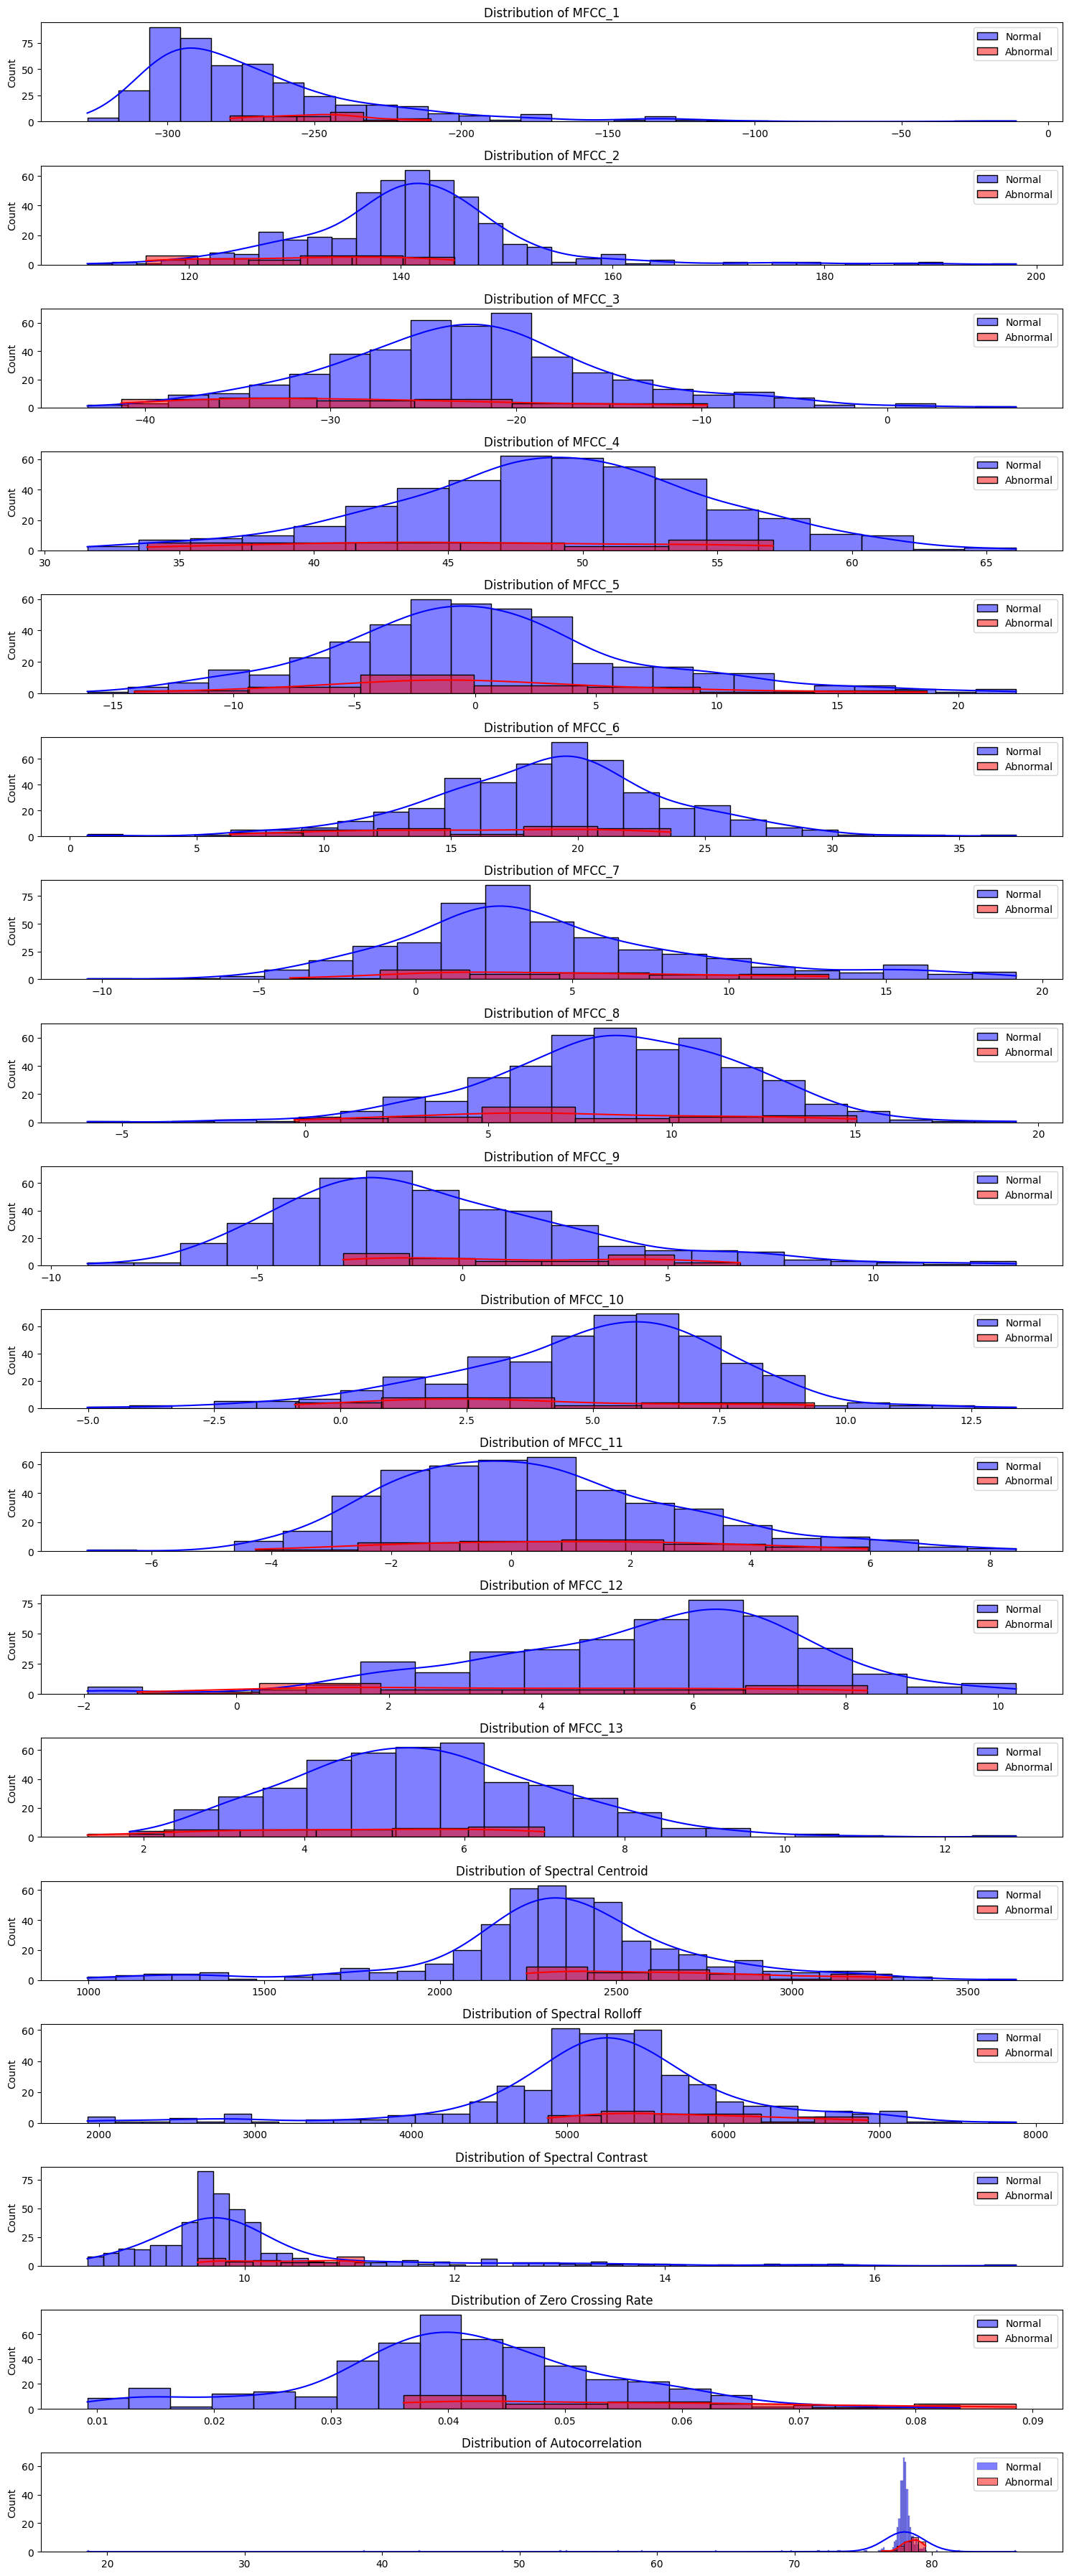

In [13]:
# Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot feature distributions
def plot_feature_distributions(normal_features, abnormal_features, feature_names):
    number_of_features = normal_features.shape[1]
    plt.figure(figsize=(15, 2 * number_of_features))
    
    for i in range(number_of_features):
        plt.subplot(number_of_features, 1, i + 1)
        sns.histplot(normal_features[:, i], color='blue', label='Normal', kde=True)
        sns.histplot(abnormal_features[:, i], color='red', label='Abnormal', kde=True)
        plt.title(f'Distribution of {feature_names[i]}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting
plot_feature_distributions(normal_features, abnormal_features, feature_names)


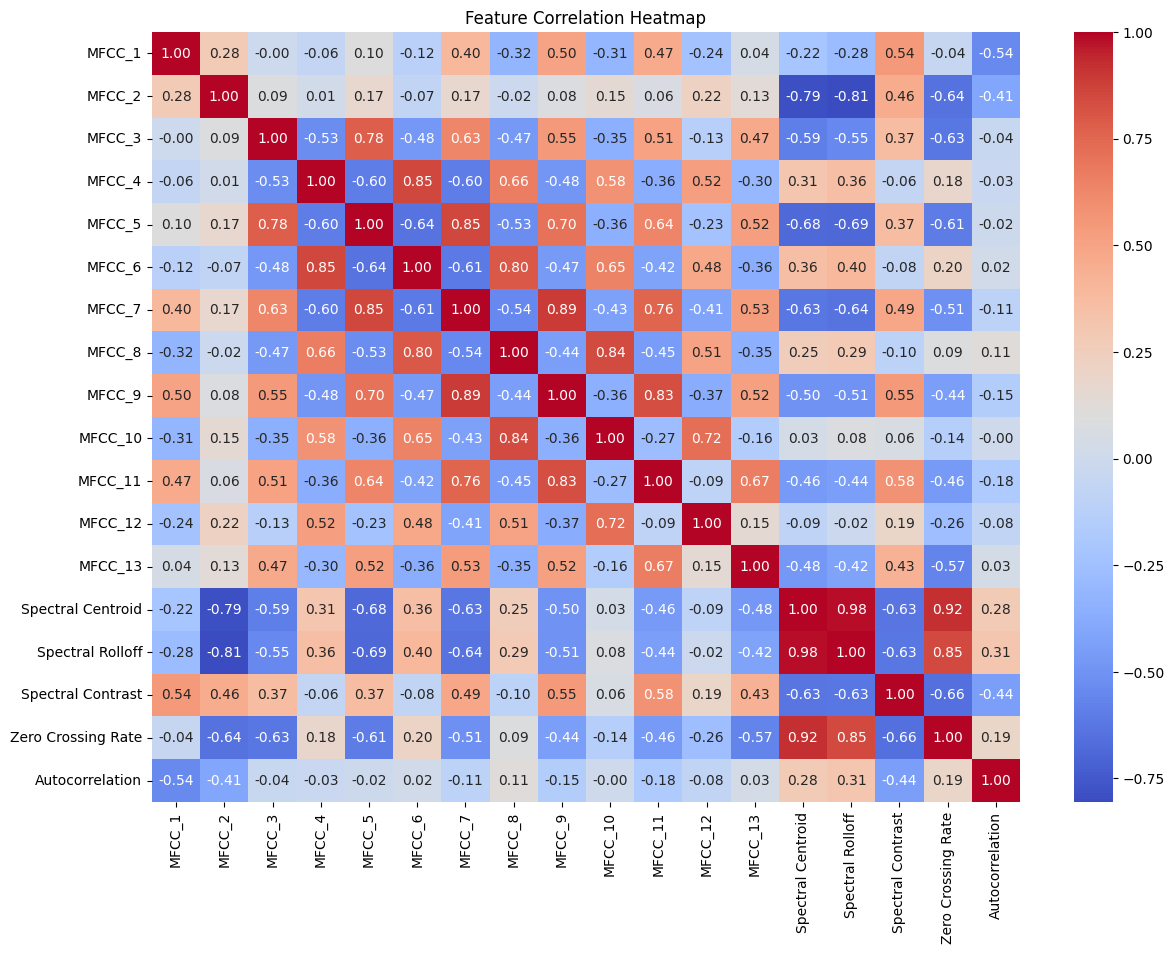

In [14]:
# Feature Correlations
import seaborn as sns

# Assuming 'features' is a combined array of normal and abnormal features
features = np.concatenate((normal_features, abnormal_features))

# Calculate the correlation matrix
corr_matrix = np.corrcoef(features.T)  # Transpose to get features as columns

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=feature_names, yticklabels=feature_names)
plt.title('Feature Correlation Heatmap')
plt.show()


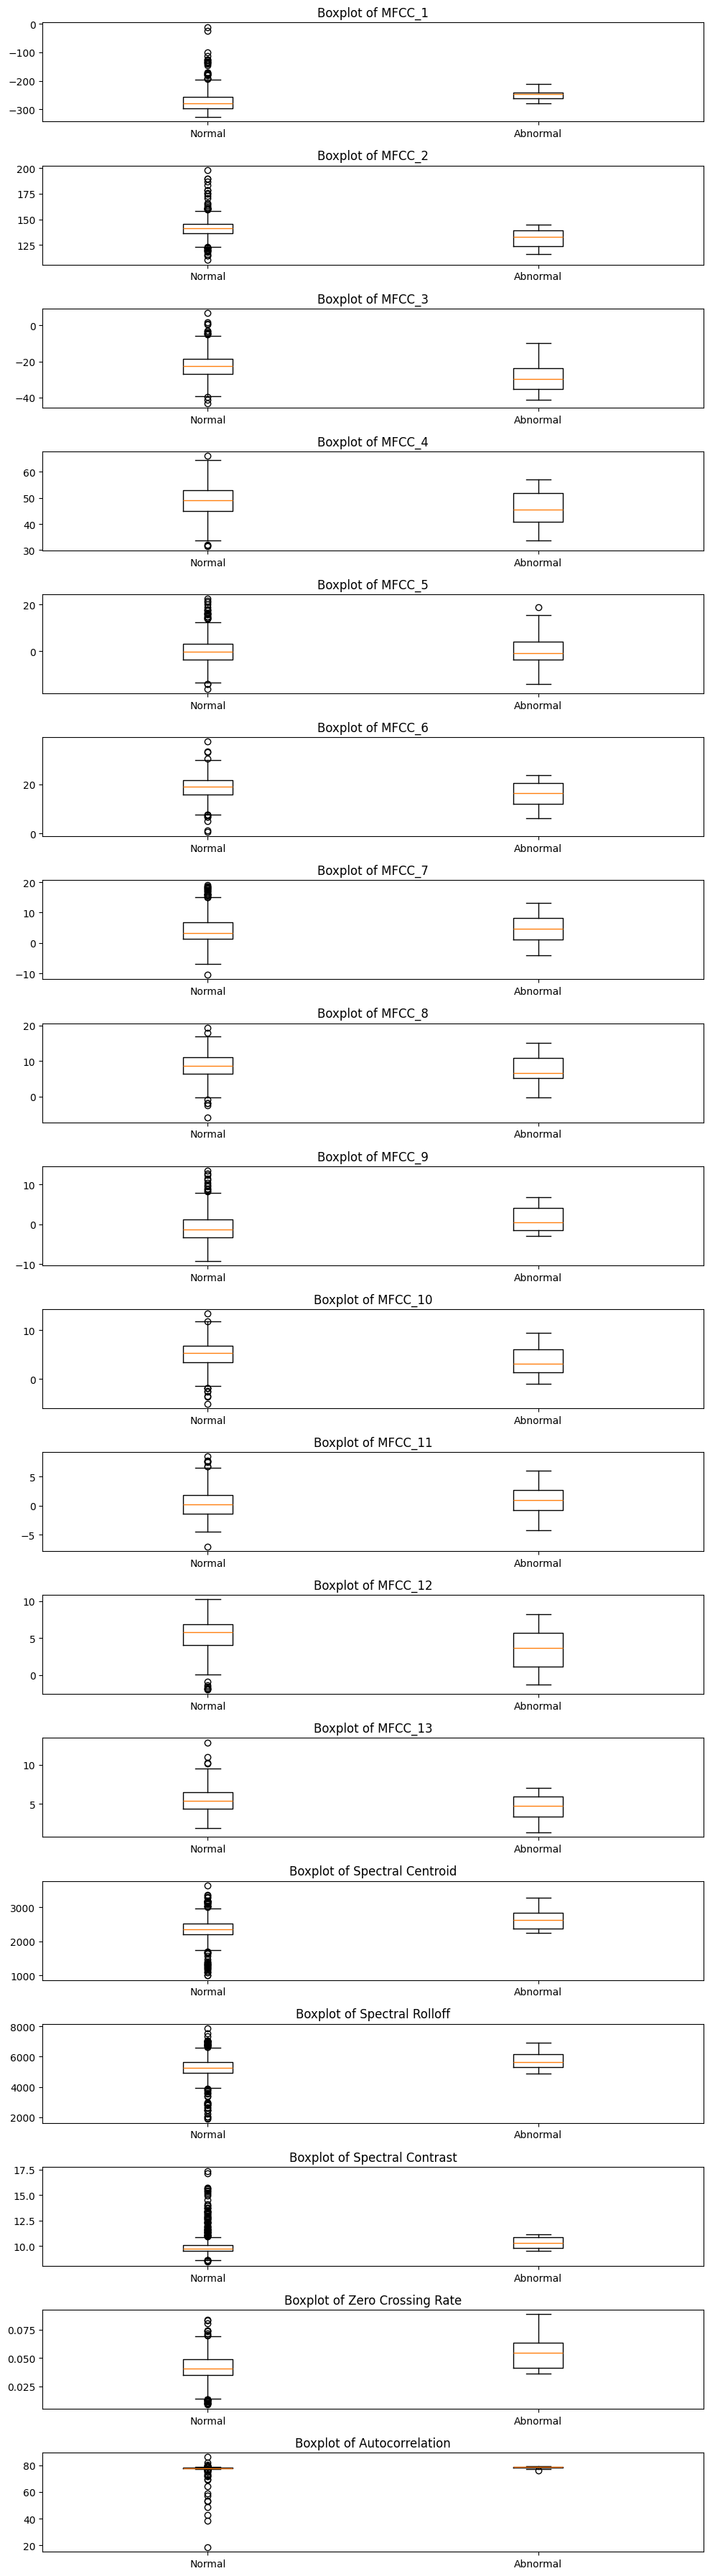

In [15]:
# Comparing Normal and Abnormal Features.
import matplotlib.pyplot as plt

# Boxplot for visualizing the distributions
def plot_feature_boxplots(normal_features, abnormal_features, feature_names):
    number_of_features = normal_features.shape[1]
    fig = plt.figure(figsize=(10, 2 * number_of_features))

    for i in range(number_of_features):
        ax = fig.add_subplot(number_of_features, 1, i + 1)
        ax.boxplot([normal_features[:, i], abnormal_features[:, i]], labels=['Normal', 'Abnormal'])
        ax.set_title(f'Boxplot of {feature_names[i]}')

    plt.tight_layout()
    plt.show()



plot_feature_boxplots(normal_features, abnormal_features, feature_names)


In [16]:
# Stastical Analysis

# Calculate mean and standard deviation for all features
for i in range(normal_features.shape[1]):
    normal_mean = np.mean(normal_features[:, i])
    normal_std = np.std(normal_features[:, i])
    abnormal_mean = np.mean(abnormal_features[:, i])
    abnormal_std = np.std(abnormal_features[:, i])
    feature = feature_names[i] 
    print(feature)
    print(f"- Normal - Mean: {normal_mean:.2f}, Std Dev: {normal_std:.2f}")
    print(f"- Abnormal - Mean: {abnormal_mean:.2f}, Std Dev: {abnormal_std:.2f}")
    print()  # Print a new line for better readability


MFCC_1
- Normal - Mean: -268.97, Std Dev: 41.29
- Abnormal - Mean: -249.15, Std Dev: 18.17

MFCC_2
- Normal - Mean: 141.32, Std Dev: 10.58
- Abnormal - Mean: 131.23, Std Dev: 8.99

MFCC_3
- Normal - Mean: -22.36, Std Dev: 7.58
- Abnormal - Mean: -27.93, Std Dev: 8.79

MFCC_4
- Normal - Mean: 48.87, Std Dev: 5.98
- Abnormal - Mean: 45.89, Std Dev: 6.98

MFCC_5
- Normal - Mean: 0.36, Std Dev: 6.38
- Abnormal - Mean: 0.33, Std Dev: 6.97

MFCC_6
- Normal - Mean: 18.91, Std Dev: 4.78
- Abnormal - Mean: 16.04, Std Dev: 4.99

MFCC_7
- Normal - Mean: 4.28, Std Dev: 4.95
- Abnormal - Mean: 4.95, Std Dev: 4.57

MFCC_8
- Normal - Mean: 8.57, Std Dev: 3.45
- Abnormal - Mean: 7.51, Std Dev: 4.09

MFCC_9
- Normal - Mean: -0.64, Std Dev: 3.70
- Abnormal - Mean: 1.16, Std Dev: 2.98

MFCC_10
- Normal - Mean: 5.01, Std Dev: 2.67
- Abnormal - Mean: 3.76, Std Dev: 2.95

MFCC_11
- Normal - Mean: 0.43, Std Dev: 2.44
- Abnormal - Mean: 0.97, Std Dev: 2.48

MFCC_12
- Normal - Mean: 5.39, Std Dev: 2.15
- Abnor

In [17]:
# Statistical Significance Tests

from scipy.stats import ttest_ind

# Perform t-tests for all features
for i in range(normal_features.shape[1]):
    t_stat, p_val = ttest_ind(normal_features[:, i], abnormal_features[:, i])
    
    # Assuming you have a list of feature names
    feature_name = feature_names[i]
    
    # Print the t-statistic and p-value for each feature
    print(f"{feature_name}:")
    print(f"  T-Stat = {t_stat:.3f}, P-value = {p_val:.3g}")
    print()


MFCC_1:
  T-Stat = -2.608, P-value = 0.0094

MFCC_2:
  T-Stat = 5.093, P-value = 5.06e-07

MFCC_3:
  T-Stat = 3.849, P-value = 0.000134

MFCC_4:
  T-Stat = 2.610, P-value = 0.00933

MFCC_5:
  T-Stat = 0.029, P-value = 0.977

MFCC_6:
  T-Stat = 3.176, P-value = 0.00159

MFCC_7:
  T-Stat = -0.717, P-value = 0.473

MFCC_8:
  T-Stat = 1.612, P-value = 0.108

MFCC_9:
  T-Stat = -2.609, P-value = 0.00935

MFCC_10:
  T-Stat = 2.465, P-value = 0.014

MFCC_11:
  T-Stat = -1.172, P-value = 0.242

MFCC_12:
  T-Stat = 4.016, P-value = 6.85e-05

MFCC_13:
  T-Stat = 2.806, P-value = 0.00522

Spectral Centroid:
  T-Stat = -4.189, P-value = 3.33e-05

Spectral Rolloff:
  T-Stat = -3.189, P-value = 0.00152

Spectral Contrast:
  T-Stat = -0.969, P-value = 0.333

Zero Crossing Rate:
  T-Stat = -5.661, P-value = 2.57e-08

Autocorrelation:
  T-Stat = -1.399, P-value = 0.162



In [18]:
# Model Development and Evaluation:

# normal_features and abnormal_features should be preprocessed for feature arrays ( Keep in mind !!)
X_train, X_val = train_test_split(normal_features, test_size=0.2, random_state=42)
X_test = abnormal_features
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training, validation, and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Combine normal and abnormal data
X_combined_test = np.concatenate((X_val_scaled, X_test_scaled))
y_combined_test = np.concatenate((np.zeros(len(X_val_scaled)), np.ones(len(X_test_scaled))))  # 0 for normal, 1 for abnormal

In [19]:
def enhanced_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoder = Dense(128, activation='relu')(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.1)(encoder)
    encoder = Dense(64, activation='relu')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.1)(encoder)
    encoder = Dense(32, activation='relu')(encoder)

    # Decoder
    decoder = Dense(64, activation='relu')(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(0.1)(decoder)
    decoder = Dense(128, activation='relu')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(0.1)(decoder)
    output_layer = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense , BatchNormalization,Dropout

def lstm_autoencoder(input_dim, timesteps, n_features):
    input_layer = Input(shape=(timesteps, n_features))

    # Encoder with LSTM
    encoder = LSTM(128, activation='relu', return_sequences=True)(input_layer)
    encoder = LSTM(64, activation='relu', return_sequences=False)(encoder)
    encoder = RepeatVector(timesteps)(encoder)

    # Decoder with LSTM
    decoder = LSTM(64, activation='relu', return_sequences=True)(encoder)
    decoder = LSTM(128, activation='relu', return_sequences=True)(decoder)
    output_layer = TimeDistributed(Dense(n_features))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [31]:
def enhanced_autoencoder_with_lstm(input_dim, timesteps, n_features):
    input_layer = Input(shape=(timesteps, n_features))

    # Encoder with LSTM
    encoder = LSTM(128, activation='relu', return_sequences=True)(input_layer)
    encoder = LSTM(64, activation='relu', return_sequences=False)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.1)(encoder)

    # Repeat Vector
    repeat_vector = RepeatVector(timesteps)(encoder)

    # Decoder with LSTM
    decoder = LSTM(64, activation='relu', return_sequences=True)(repeat_vector)
    decoder = LSTM(128, activation='relu', return_sequences=True)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(0.1)(decoder)
    output_layer = TimeDistributed(Dense(n_features, activation='sigmoid'))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

X_train, X_val = train_test_split(normal_features, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Print the shape of your data
print("Shape of X_train_scaled:", X_train_scaled.shape)

# Calculate the total number of elements
total_elements = np.prod(X_train_scaled.shape)
print("Total number of elements:", total_elements)

n_samples, n_features = X_train_scaled.shape

# Find suitable timesteps
for timesteps in range(1, n_samples + 1):
    if n_samples % timesteps == 0:
        reshaped_samples = n_samples // timesteps
        if reshaped_samples * timesteps * n_features == n_samples * n_features:
            print(f"Suitable timesteps: {timesteps}")
            break

# Reshaping for LSTM Input
timesteps = 1  # Should be adjusted as we scale.
n_features = normal_features.shape[1]
X_train_reshaped = X_train_scaled.reshape((-1, timesteps, n_features))
X_val_reshaped = X_val_scaled.reshape((-1, timesteps, n_features))

# Model Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder = enhanced_autoencoder_with_lstm(input_dim=n_features, timesteps=timesteps, n_features=n_features)
autoencoder.fit(
    X_train_reshaped, X_train_reshaped,
    epochs=400,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val_reshaped, X_val_reshaped),
    callbacks=[early_stopping],
    verbose=0
)

Shape of X_train_scaled: (365, 18)
Total number of elements: 6570
Suitable timesteps: 1


In [21]:
def model_training(X_train_scaled, X_val_scaled):
    # Adjust input_dim based on your feature dimensions
    input_dim = X_train_scaled.shape[1]
    autoencoder = enhanced_autoencoder(input_dim)
    # autoencoder = lstm_autoencoder(input_dim, timesteps=1, n_features=input_dim)
    autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=400,  # Experiment with different epochs
    batch_size=256,
    shuffle=True,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=[early_stopping],
    verbose=0
    )
    return autoencoder

In [32]:
def model_evaluation(autoencoder,X_combined_test):
    reconstructed_combined = autoencoder.predict(X_combined_test)
    mse_combined = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=1)
    precisions, recalls, thresholds = precision_recall_curve(y_combined_test, mse_combined)
    # Calculate precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_combined_test, mse_combined)

    # Calculate F1 score for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # Use the optimal threshold to define anomalies
    optimal_predictions = (mse_combined > optimal_threshold).astype(int)

    # Calculate metrics using the optimal threshold
    optimal_accuracy = accuracy_score(y_combined_test, optimal_predictions)
    optimal_precision = precision_score(y_combined_test, optimal_predictions)
    optimal_recall = recall_score(y_combined_test, optimal_predictions)
    optimal_f1 = f1_score(y_combined_test, optimal_predictions)

    # Print metrics using the optimal threshold
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Accuracy: {optimal_accuracy}")
    print(f"Precision: {optimal_precision}")
    print(f"Recall: {optimal_recall}")
    print(f"F1 Score: {optimal_f1}")

    # Plot confusion matrix using the optimal threshold
    optimal_cm = confusion_matrix(y_combined_test, optimal_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(optimal_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Optimal Confusion Matrix')
    plt.show()

2023-12-20 14:05:27.650672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 14:05:27.651413: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 0s 1ms/step
Optimal Threshold: 3.263575019067156
Accuracy: 0.7377049180327869
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/tmp/ipykernel_59926/378948608.py:9: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


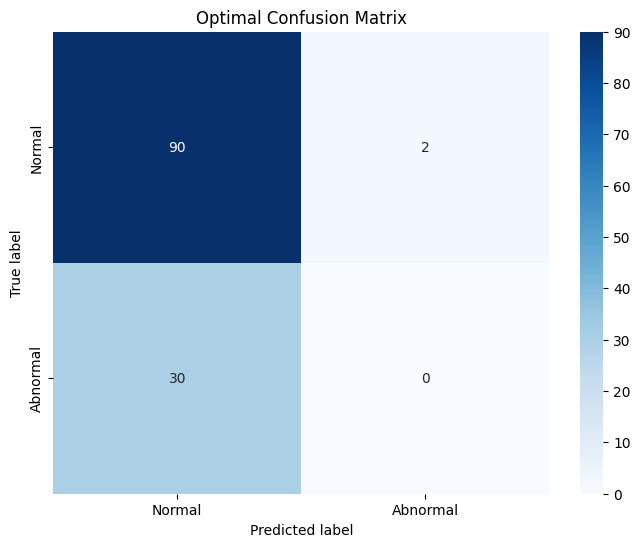

In [23]:
autoencoder = model_training(X_train_scaled, X_val_scaled)
model_evaluation(autoencoder,X_combined_test)

In [24]:
autoencoder.save('Encoder_Model.keras')

In [25]:
# Predict the reconstructed sounds for the combined test set
reconstructed_combined = autoencoder.predict(X_combined_test)

# Calculate the mean squared reconstruction error for each feature
mse_features = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=0)

# Rank features by reconstruction error
feature_importance_ranking = np.argsort(mse_features)[::-1]  # Features with the highest error first


# Print out the feature ranking with feature names
print("Feature importance ranking (from most to least important):")
for rank in feature_importance_ranking:
    print(f"{feature_names[rank]}: MSE = {mse_features[rank]}")

4/4 [==============================] - 0s 1ms/step
Feature importance ranking (from most to least important):
MFCC_12: MSE = 1.4181022390362832
MFCC_3: MSE = 1.1013867165646505
MFCC_4: MSE = 1.0254109905616986
MFCC_6: MSE = 0.9316582633684382
MFCC_2: MSE = 0.9187267250437751
MFCC_10: MSE = 0.8983176279366462
MFCC_13: MSE = 0.8041828094317812
MFCC_8: MSE = 0.7920431978194001
MFCC_5: MSE = 0.656384801111239
MFCC_11: MSE = 0.6480533727903395
Zero Crossing Rate: MSE = 0.624307367820962
Spectral Centroid: MSE = 0.4981568292512989
Spectral Rolloff: MSE = 0.4833544961185342
MFCC_7: MSE = 0.47116404058504263
MFCC_9: MSE = 0.4572255870021412
Spectral Contrast: MSE = 0.356752230791753
MFCC_1: MSE = 0.30393092494379875
Autocorrelation: MSE = 0.227812664439199


In [32]:
# Extra Feature Extraction:

def extract_additional_features(audio, sample_rate):
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)
    spec_flatness = librosa.feature.spectral_flatness(y=audio)
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)
    rms = librosa.feature.rms(y=audio)
    
    return np.mean(chroma_stft), np.mean(spec_bw), np.mean(spec_flatness), np.mean(rolloff), np.mean(rms)

def extract_features(audio_data, sample_rate):
    features = []
    for audio in audio_data:
        mfccs = extract_mfccs(audio, sample_rate)
        spectral_features = extract_spectral_features(audio, sample_rate)
        temporal_features = extract_temporal_features(audio)
        additional_features = extract_additional_features(audio, sample_rate)
        all_features = np.concatenate([mfccs, spectral_features, temporal_features, additional_features])
        features.append(all_features)
    return np.array(features)

# Extract features for both normal and abnormal data
normal_features = extract_features(normal_audio, sample_rate)
abnormal_features = extract_features(abnormal_audio, sample_rate)

In [33]:
normal_features.shape

(381, 23)

In [34]:
# Adding additional features to features list
additional_features = ['Chroma Features', 'Spectral Bandwidth', 'Spectral Flatness', 'Spectral Roll-off Frequency', 'Root Mean Square Energy']

# Combine all feature labels into a single list
feature_names = feature_names + additional_features
feature_names

['MFCC_1',
 'MFCC_2',
 'MFCC_3',
 'MFCC_4',
 'MFCC_5',
 'MFCC_6',
 'MFCC_7',
 'MFCC_8',
 'MFCC_9',
 'MFCC_10',
 'MFCC_11',
 'MFCC_12',
 'MFCC_13',
 'Spectral Centroid',
 'Spectral Rolloff',
 'Spectral Contrast',
 'Zero Crossing Rate',
 'Autocorrelation',
 'Chroma Features',
 'Spectral Bandwidth',
 'Spectral Flatness',
 'Spectral Roll-off Frequency',
 'Root Mean Square Energy']

In [35]:
X_train, X_val = train_test_split(normal_features, test_size=0.2, random_state=42)
X_test = abnormal_features

scaler = StandardScaler()

# Fit the scaler on the training data and transform both training, validation, and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Combine normal and abnormal data
X_combined_test = np.concatenate((X_val_scaled, X_test_scaled))
y_combined_test = np.concatenate((np.zeros(len(X_val_scaled)), np.ones(len(X_test_scaled))))  # 0 for normal, 1 for abnormal

7/7 [==============================] - 0s 2ms/step
Optimal Threshold: 0.9311662182264268
Accuracy: 0.9255813953488372
Precision: 0.9178082191780822
Recall: 0.9710144927536232
F1 Score: 0.943661971830986


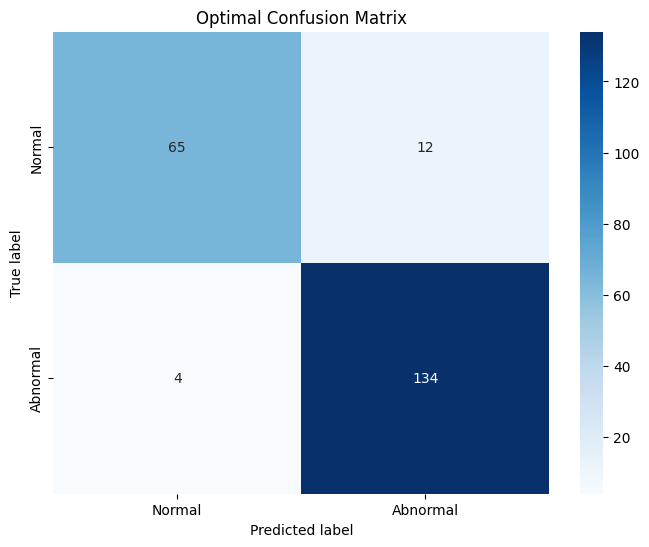

In [36]:
autoencoder = model_training(X_train_scaled, X_val_scaled)
# model_evaluation(autoencoder,X_combined_test)

In [37]:
autoencoder.save('Encoder_Model2.keras')

In [38]:
# Predict the reconstructed sounds for the combined test set
reconstructed_combined = autoencoder.predict(X_combined_test)

# Calculate the mean squared reconstruction error for each feature
mse_features = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=0)

# Rank features by reconstruction error
feature_importance_ranking = np.argsort(mse_features)[::-1]  # Features with the highest error first

# Print out the feature ranking with feature names
print("Feature importance ranking (from most to least important):")
for rank in feature_importance_ranking:
    print(f"{feature_names[rank]}: MSE = {mse_features[rank]}")

7/7 [==============================] - 0s 844us/step
Feature importance ranking (from most to least important):
Autocorrelation: MSE = 276.3789637479361
Root Mean Square Energy: MSE = 71.4517664857988
Spectral Bandwidth: MSE = 9.140279723318553
MFCC_5: MSE = 7.763670796177632
MFCC_8: MSE = 6.3338961394204665
Spectral Roll-off Frequency: MSE = 5.615388850681344
Spectral Rolloff: MSE = 5.604150405105396
MFCC_1: MSE = 5.083258124913937
MFCC_9: MSE = 4.650789562053645
MFCC_6: MSE = 3.646895984067652
MFCC_4: MSE = 2.668005705488088
MFCC_2: MSE = 2.6135563310646726
Spectral Centroid: MSE = 2.493009632781979
MFCC_7: MSE = 2.483383357355259
MFCC_10: MSE = 1.917292599576214
MFCC_13: MSE = 1.7419691876394277
Spectral Flatness: MSE = 1.597201087614089
MFCC_11: MSE = 1.5576472681509264
MFCC_12: MSE = 1.2258477884030576
MFCC_3: MSE = 1.1277408570098857
Zero Crossing Rate: MSE = 1.0041990315543385
Chroma Features: MSE = 0.9702604178662694
Spectral Contrast: MSE = 0.8603600444385953


In [39]:
# Select the top N features
N = 10  # By trying different values
top_features_indices = feature_importance_ranking[:N]
top_features=[]
for rank in feature_importance_ranking[:N]:
    top_features.append(feature_names[rank])

top_features

['Autocorrelation',
 'Root Mean Square Energy',
 'Spectral Bandwidth',
 'MFCC_5',
 'MFCC_8',
 'Spectral Roll-off Frequency',
 'Spectral Rolloff',
 'MFCC_1',
 'MFCC_9',
 'MFCC_6']

In [40]:
# Subset the features for both normal and abnormal data
normal_features_subset = normal_features[:, top_features_indices]
abnormal_features_subset = abnormal_features[:, top_features_indices]

# Split and scale the data as before
X_train_subset, X_val_subset = train_test_split(normal_features_subset, test_size=0.2, random_state=42)
X_test_subset = abnormal_features_subset

scaler_subset = StandardScaler()
X_train_subset_scaled = scaler_subset.fit_transform(X_train_subset)
X_val_subset_scaled = scaler_subset.transform(X_val_subset)
X_test_subset_scaled = scaler_subset.transform(X_test_subset)

# Combine normal and abnormal data
X_combined_test = np.concatenate((X_val_subset_scaled, X_test_subset_scaled))
y_combined_test = np.concatenate((np.zeros(len(X_val_scaled)), np.ones(len(X_test_scaled))))  # 0 for normal, 1 for abnormal

7/7 [==============================] - 0s 2ms/step
Optimal Threshold: 1.1442864890465247
Accuracy: 0.9488372093023256
Precision: 0.9568345323741008
Recall: 0.9637681159420289
F1 Score: 0.9602888086642598


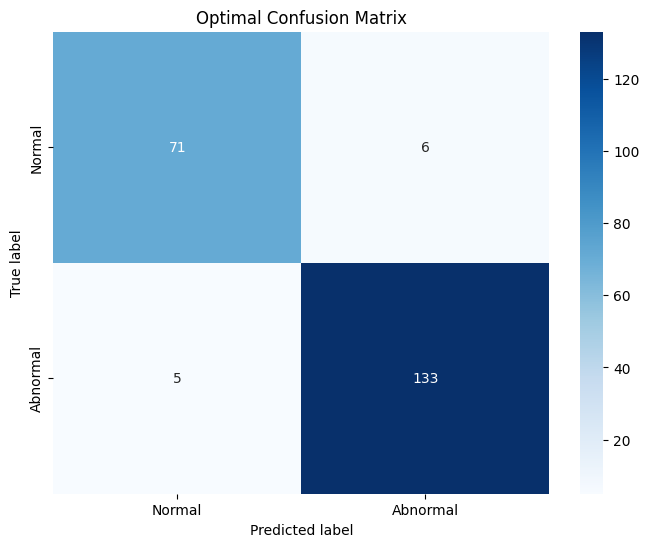

In [41]:
autoencoder2 = model_training(X_train_subset_scaled, X_val_subset_scaled)
model_evaluation(autoencoder2,X_combined_test)

In [42]:
# Predict the reconstructed sounds for the combined test set
reconstructed_combined = autoencoder2.predict(X_combined_test)

# Calculate the mean squared reconstruction error for each feature
mse_features = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=0)

# Rank features by reconstruction error
feature_importance_ranking = np.argsort(mse_features)[::-1]  # Features with the highest error first


# Print out the feature ranking with feature names
print("Feature importance ranking (from most to least important):")
for rank in feature_importance_ranking:
    print(f"{top_features[rank]}: MSE = {mse_features[rank]}")

7/7 [==============================] - 0s 906us/step
Feature importance ranking (from most to least important):
Autocorrelation: MSE = 276.3495293662009
Root Mean Square Energy: MSE = 71.42700947145534
Spectral Bandwidth: MSE = 9.1097373807892
MFCC_5: MSE = 8.313428841525306
MFCC_8: MSE = 8.020873280243853
Spectral Rolloff: MSE = 7.030834587702043
Spectral Roll-off Frequency: MSE = 6.986303759638644
MFCC_1: MSE = 5.1257161727484135
MFCC_9: MSE = 4.494085511959198
MFCC_6: MSE = 3.676079493103074


In [43]:
autoencoder2.save('Encoder_Model3.keras')

In [ ]:
# FEARURRE DISRTRIBUTION
# MSE Distribution over hours
# Plot the AutoEncoder.
# Overlapping window